Raul Jimenez Ayza, NIU: 1688916

Marc Estape Ayen, NIU: 1630270

GitHub : https://github.com/NIU1688916/Kaggle_LOL

# Cas Kaggle: League of Legends Ranked Games


Installs neccessaris per funcionament de practica:

In [16]:
#es para instalar el kaggle-->con ! o %
# %pip install kaggle 
# %pip install seaborn

Imports:

In [2]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (train_test_split, StratifiedKFold,  GridSearchCV, cross_val_score)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_squared_error, mean_absolute_error, make_scorer, r2_score, precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

Archius del cas:

In [3]:
api = KaggleApi()
#api.config  = os.path.join(os.getcwd(),'kaggle.json')
api.authenticate()

dataser_owner = 'datasnaek'
dataset_name= 'league-of-legends'
dataset = f'{dataser_owner}/{dataset_name}'

if not os.path.isdir('data_kaggle'):
  os.mkdir('data_kaggle')
  api.dataset_download_files(dataset = dataset,path = 'data_kaggle')
  zf = ZipFile(f'data_kaggle/{dataset_name}.zip')
  zf.extractall(f'data_kaggle/{dataset_name}') #save files in selected folder
  zf.close()

df = pd.read_csv(f'data_kaggle/{dataset_name}/games.csv')

print(df.head(10))

       gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0  3326086514  1504279457970          1949         9       1           2   
1  3229566029  1497848803862          1851         9       1           1   
2  3327363504  1504360103310          1493         9       1           2   
3  3326856598  1504348503996          1758         9       1           1   
4  3330080762  1504554410899          2094         9       1           2   
5  3287435705  1501667992132          2059         9       1           2   
6  3314215542  1503430065724          1993         9       1           1   
7  3329224025  1504472363684          1334         9       1           1   
8  3318040883  1503686577549          1387         9       2           2   
9  3327786881  1504385918871          2681         9       2           2   

   firstTower  firstInhibitor  firstBaron  firstDragon  ...  t2_towerKills  \
0           1               1           1            1  ...              5   
1      

In [4]:
numero = df.shape[1]
noms = df.columns.tolist()
print("Número d'atributs:", numero)
print("Atributs:", noms)
df.info()

Número d'atributs: 61
Atributs: ['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']

Hem observat que totes les variables són del tipus `int64` i que, aparentment, no hi ha cap dada `NaN`. Tot i això, més endavant ho comprovarem amb més detall.
Abans de res, hem analitzat visualment i aplicat la lògica per concloure que les columnes `creationTime`, `seasonId` i `gameId` no aporten informació rellevant per al desenvolupament de la partida. Per aquest motiu, les eliminarem de les nostres mostres.

In [5]:
#Treiem les que visualment sabem que no ens donen cap tipus d'informacio:
df=df.drop(columns=['creationTime','seasonId','gameId'])

Per poder continuar, farem una breu anàlisi de la correlació entre les variables per identificar quines poden aportar més informació i quines en proporcionen menys.

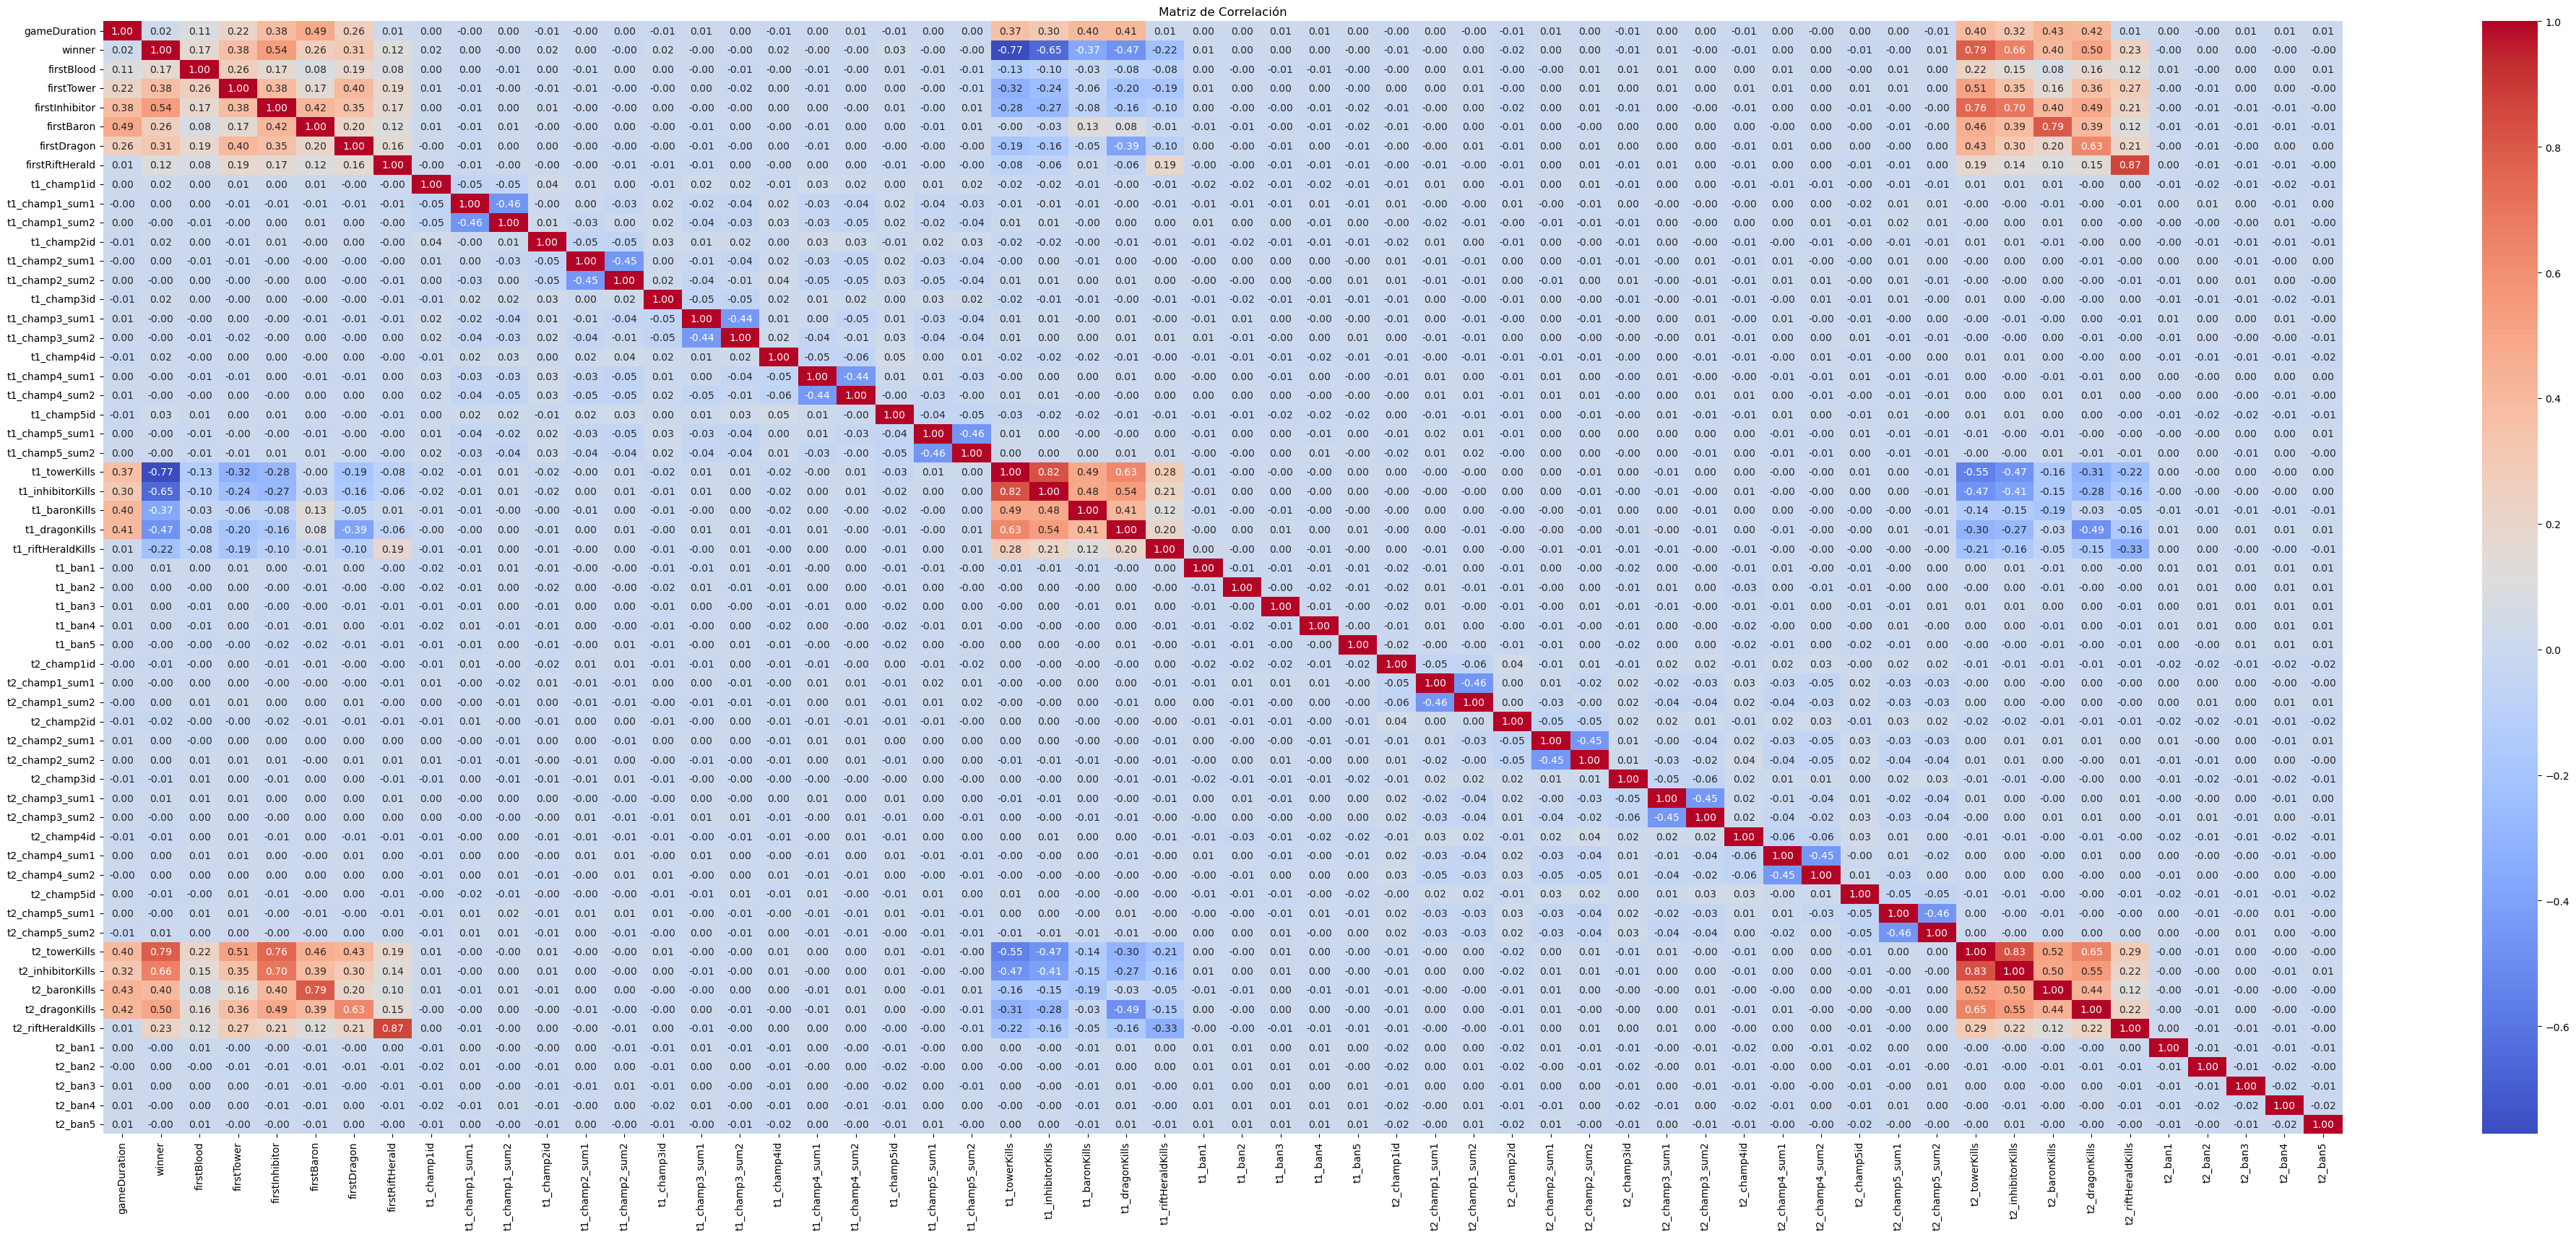

In [6]:
#Anem a veure la informacio que ens donen la resta de variables
correlation_matrix = df.corr()
plt.figure(figsize=(50, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Després d'analitzar els resultats, hem decidit que les dades més rellevants per al nostre model són les següents: 

- **Variables generals:** `winner`, `firstBlood`, `firstTower`, `firstInhibitor`, `firstBaron`, `firstDragon`, `firstRiftHerald`.
- **Estadístiques de l'equip 1:** `t1_towerKills`, `t1_inhibitorKills`, `t1_baronKills`, `t1_dragonKills`, `t1_riftHeraldKills`.
- **Estadístiques de l'equip 2:** `t2_towerKills`, `t2_inhibitorKills`, `t2_baronKills`, `t2_dragonKills`, `t2_riftHeraldKills`.

Aquestes variables ens proporcionen informació significativa per al desenvolupament del model, ja que reflecteixen els factors clau que poden influir en l'evolució i el resultat de la partida.

In [7]:
#Agafem nomes les variables que ens aporten.
df=df[['winner','firstBlood','firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald','t1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills','t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills',]]

print("\nNulls:")
df.isnull().sum()



Nulls:


winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
t1_riftHeraldKills    0
t2_towerKills         0
t2_inhibitorKills     0
t2_baronKills         0
t2_dragonKills        0
t2_riftHeraldKills    0
dtype: int64

També hem verificat que cap d'aquestes variables contingui valors `NaN`, ja que, en cas contrari, hauríem de tractar-los. Afortunadament, en el nostre cas, no hi ha cap valor d'aquest tipus, per la qual cosa disposem de dades netes i llestes per ser utilitzades.

Fem una breu anàlisi de la nostra variable objectiu:

In [8]:
print(df.dtypes['winner'])
print(df['winner'].unique())

int64
[1 2]


Observem que la nostra variable objectiu oscil·la entre dos valors, 1 i 2, que indiquen quin és l’equip guanyador. A més, hem comprovat que aquesta variable és del tipus int64.

In [9]:
# Tamany de les dades d'entrenament
print("Mida de les dades d'entrenament:", df.shape)

Mida de les dades d'entrenament: (51490, 17)


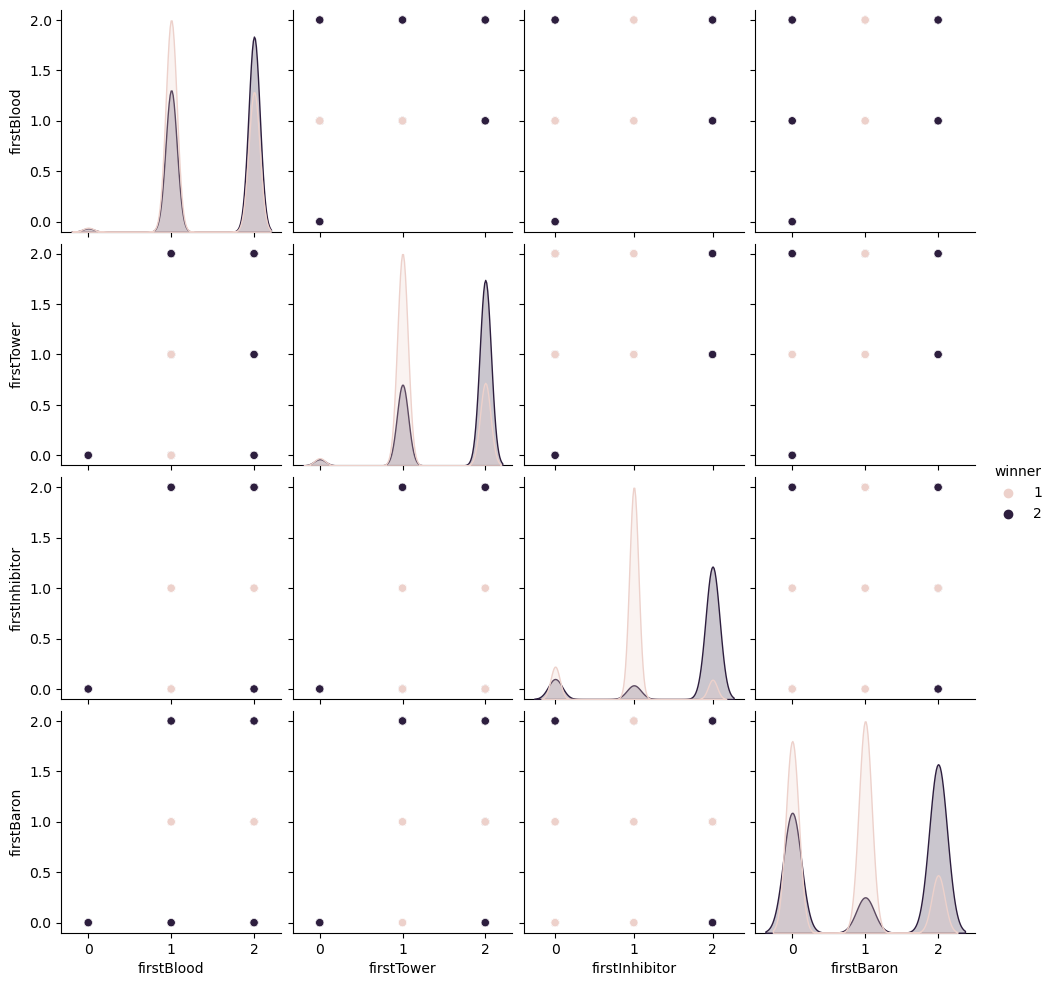

In [25]:
dfPlot = df.iloc[:,:5]
sns.pairplot(dfPlot, hue='winner')

Com podem veure a les gràfiques, la nostra variable objectiu presenta una distribució equilibrada entre els valors `1` i `2`, que corresponen als equips guanyadors. Aquesta distribució equitativa és un avantatge, ja que redueix el risc de biaixos en el model i facilita que el procés d'entrenament i validació sigui més robust i representatiu. Aquest equilibri també ens permet confiar que els resultats del model seran més fiables i generalitzables.

Ara procedirem a realitzar una anàlisi de correlació entre les variables seleccionades i la variable objectiu. Aquesta anàlisi ens permetrà identificar quines variables tenen una relació més estreta amb la variable `winner` i, per tant, quines podrien ser més útils per al model.

Utilitzarem una matriu de correlació i, visualitzarem els resultats amb un mapa de calor per facilitar la interpretació.

Aquest procés ens ajudarà a validar la importància de les variables seleccionades i a entendre millor el seu impacte en el model.

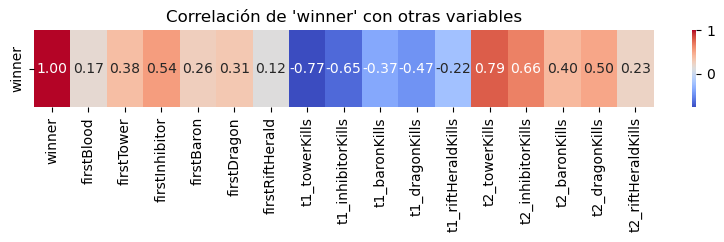

In [26]:
# Seleccionar la fila correspondiente a "winner" en la matriz de correlación
correlation_matrix = df.corr()
winner_correlation = correlation_matrix.loc[['winner']]

# Visualización de la fila de "winner" en un mapa de calor
plt.figure(figsize=(10, 1))  # Ajustar el tamaño para mostrar solo una fila
sns.heatmap(winner_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlación de 'winner' con otras variables")
plt.show()

1. **Variables amb alta correlació positiva amb `winner`:**
   - `firstInhibitor` (0.54): Hi ha una forta correlació entre l'esdeveniment de `firstInhibitor` i la victòria, indicant que l'equip que aconsegueix destruïr el primer inhibidor té més probabilitats de guanyar.
   - `firstTower` (0.38): També hi ha una correlació notable entre l'equip que aconsegueix la primera torre i la victòria.
   - `firstDragon` (0.31): La correlació és més moderada, però encara suggereix que el primer drac pot tenir una influència positiva en el guanyador.

2. **Variables amb correlació negativa forta amb `winner`:**
   - `t1_towerKills` (-0.77): Aquesta correlació negativa forta suggereix que, a mesura que un equip rep més "tower kills" (és a dir, les torres enemigues maten més jugadors de l'equip), és menys probable que guanyi. Aquest resultat és comprensible, ja que si un equip és més vulnerable a les torres enemigues, probablement està en una posició més feble.
   - `t1_inhibitorKills` (-0.65), `t1_baronKills` (-0.37): Aquestes variables també tenen una correlació negativa moderada a forta, suggerint que aquests esdeveniments poden estar associats amb una victòria per l'equip contrari.

El mateix pero en cas contrari pel que fa el t2.


# Mètriques i selecció de model


Valors amb GradientBoostingClassifier:

In [10]:
# Definir les columnes i la variable objectiu
columnas = ['firstBlood','firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald','t1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills','t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills']
target = 'winner'

X = df[columnas]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)

# Crear i entrenar el model GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=26)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluar el model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9733928918236551

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.97      2563
           2       0.98      0.97      0.97      2586

    accuracy                           0.97      5149
   macro avg       0.97      0.97      0.97      5149
weighted avg       0.97      0.97      0.97      5149


Confusion Matrix:
[[2503   60]
 [  77 2509]]


Valors amb RandomForest:

In [ ]:
X = df[columnas]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)

# Crear i entrenar el model RandomForestClassifier
model_rf = RandomForestClassifier(random_state=26)
model_rf.fit(X_train, y_train)

# Predir al conjunt de prova
y_pred_rf = model_rf.predict(X_test)

# Evaluar el model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.9702854923286075

Classification Report (Random Forest):
              precision    recall  f1-score   support

           1       0.97      0.97      0.97      2563
           2       0.97      0.97      0.97      2586

    accuracy                           0.97      5149
   macro avg       0.97      0.97      0.97      5149
weighted avg       0.97      0.97      0.97      5149


Confusion Matrix (Random Forest):
[[2493   70]
 [  83 2503]]


Valors amb AdaBoostClassifier:

In [ ]:
X = df[columnas]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)

# Crear i entrenar el model AdaBoostClassifier
model_ada = AdaBoostClassifier(random_state=26)
model_ada.fit(X_train, y_train)

# Predir al conjunt de prova
y_pred_ada = model_ada.predict(X_test)

# Evaluar el model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'Ada Boosting Accuracy: {accuracy_ada}')

print("\nClassification Report (Ada Boosting):")
print(classification_report(y_test, y_pred_ada))

print("\nConfusion Matrix (Ada Boosting):")
print(confusion_matrix(y_test, y_pred_ada))

Ada Boosting Accuracy: 0.9683433676442028

Classification Report (Ada Boosting):
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      2563
           2       0.98      0.96      0.97      2586

    accuracy                           0.97      5149
   macro avg       0.97      0.97      0.97      5149
weighted avg       0.97      0.97      0.97      5149


Confusion Matrix (Ada Boosting):
[[2505   58]
 [ 105 2481]]


# Entrenament

In [ ]:
#Agafem X com característiques i Y com a variable objectiu.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Definim els models seleccionats i les seves caracterisitques a provar
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier()
}
params = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 150, 200, 300],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'class_weight': [None, 'balanced','desbalanced'],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [1, 3, 5, 7, 8],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0], 
        'max_features': ['sqrt', 'log2'] 
    }
}

resultat_GS = []
best_params_GS = {}

for model_name, model in models.items():

    print(f"Buscant hiperparàmetres òptims per {model_name}...")

    # Trobar els millors hiperparàmetres amb Grid Search
    grid_search = GridSearchCV(model, params[model_name], cv=kfold, scoring='accuracy', n_jobs=-1)  
    grid_search.fit(x_train, y_train) 
    estimator = grid_search.best_estimator_

    best_params_GS[model_name] = grid_search.best_params_

    #Evaluar els models amb aquests paràmetres
    y_pred_test_GS = estimator.predict(x_test)
    accuracy_result_GS = accuracy_score(y_test, y_pred_test_GS)

    # Guardem els resultats del model
    resultat_GS.append([model_name, grid_search.best_score_, accuracy_result_GS])

# Mostrem els resultats obtinguts
print("\nPuntuacions Grid Search: ")

resultat_GS_df = pd.DataFrame(resultat_GS, columns=['Model', 'Accuracy Score Train ', 'Accuracy Score Test'])
print(resultat_GS_df)
print("\nMillors paràmetres GS: ")
print(best_params_GS)

#¡¡CUIDADO 68min de ejeccucion!!

Buscando hiperparámetros óptimos para RandomForestClassifier...
Buscando hiperparámetros óptimos para AdaBoostClassifier...
Buscando hiperparámetros óptimos para GradientBoostingClassifier...

Puntuacions Grid Search: 
                        Model  Accuracy Score Train   Accuracy Score Test
0      RandomForestClassifier               0.972300             0.971159
1          AdaBoostClassifier               0.968246             0.968635
2  GradientBoostingClassifier               0.972470             0.971742

Millors paràmetres GS: 
{'RandomForestClassifier': {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}, 'AdaBoostClassifier': {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200}, 'GradientBoostingClassifier': {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 1.0}}


Veiem que el model que ens està donant millors resultats és el Gradient Boosting Classifier, així que serà el model que utilitzarem per a l'anàlisi final.

# Analisis Final


Creem una funció que ens permeti mostrar les curves ROC i PR per comprovar la mètrica de F1:

In [ ]:
def plot_performance_curve(model, X_test, y_test, curve_type="pr"):

    # Normalitzem els valors ja que no es entre 1-0 sino 2-1
    y_test_binary = np.where(y_test == 2, 1, 0)  # Assumeix que 2 = guanyar i 1 = perdre
     
    # Generem les probabilitats de predicció
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Inicialitzem valors per a guardar les mètriques
    metrics = {}

    if curve_type == "pr":
        # Calculem la corba Precision-Recall
        precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_prob)
        
        # Calculem l'AUC de la corba Precision-Recall
        auc_value = auc(recall, precision)
        metrics["AUC"] = (auc_value, None, None)
        
        # Trobar el punt òptim (màxim F1-score)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]
        metrics["Punt Òptim (F1)"] = (optimal_threshold, optimal_precision, optimal_recall)
        
        # Trobar la precisió màxima
        max_precision_idx = np.argmax(precision)
        max_precision = precision[max_precision_idx]
        max_precision_recall = recall[max_precision_idx]
        metrics["Màxima Precisió"] = (thresholds[max_precision_idx - 1] if max_precision_idx > 0 else 0, max_precision, max_precision_recall)
        
        # Trobar el recall màxim
        max_recall_idx = np.argmax(recall)
        max_recall = recall[max_recall_idx]
        max_recall_precision = precision[max_recall_idx]
        metrics["Màxim Recall"] = (thresholds[max_recall_idx - 1] if max_recall_idx > 0 else 0, max_recall_precision, max_recall)
        
        # Gràfic de la corba Precision-Recall amb punts d'interès
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, color='darkorange', lw=2, label=f'PRC (AUC = {auc_value:.2f})')
        no_skill = len(y_test[y_test == 1]) / len(y_test)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='grey', label='Sense habilitat')
        plt.scatter(optimal_recall, optimal_precision, c='green', marker='o', s=100, label=f'Punt òptim (F1 = {f1_scores[optimal_idx]:.2f})')
        plt.scatter(max_precision_recall, max_precision, c='blue', marker='o', s=100, label='Màxima Precisió')
        plt.scatter(max_recall, max_recall_precision, c='red', marker='o', s=100, label='Màxim Recall')
        plt.xlabel('Recall')
        plt.ylabel('Precisió')
        plt.title('Corba Precision-Recall')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    elif curve_type == "roc":
        # Calculem la corba ROC
        fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)
        
        # Calculem l'AUC de la corba ROC
        auc_value = auc(fpr, tpr)
        metrics["AUC"] = (auc_value, None, None)
        
        # Trobar el punt òptim (màxim F1-score)
        f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        metrics["Punt Òptim (F1)"] = (optimal_threshold, optimal_fpr, optimal_tpr)
        
        # FPR mínim (precisió màxima en la corba ROC)
        min_fpr_idx = np.argmin(fpr)
        min_fpr = fpr[min_fpr_idx]
        max_tpr_at_min_fpr = tpr[min_fpr_idx]
        metrics["Mínim FPR"] = (thresholds[min_fpr_idx], min_fpr, max_tpr_at_min_fpr)
        
        # TPR màxim
        max_tpr_idx = np.argmax(tpr)
        max_tpr = tpr[max_tpr_idx]
        min_fpr_at_max_tpr = fpr[max_tpr_idx]
        metrics["Màxim TPR"] = (thresholds[max_tpr_idx], min_fpr_at_max_tpr, max_tpr)
        
        # Gràfic de la corba ROC amb punts d'interès
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_value:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Sense habilitat')
        plt.scatter(optimal_fpr, optimal_tpr, c='green', marker='o', s=100, label=f'Punt òptim (F1 = {f1_scores[optimal_idx]:.2f})')
        plt.scatter(min_fpr, max_tpr_at_min_fpr, c='blue', marker='o', s=100, label='Mínim FPR')
        plt.scatter(min_fpr_at_max_tpr, max_tpr, c='red', marker='o', s=100, label='Màxim TPR')
        plt.xlabel('Taxa de Falsos Positius (FPR)')
        plt.ylabel('Taxa de Veritables Positius (TPR)')
        plt.title('Corba ROC')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    
    # Convertim el diccionari de mètriques a un DataFrame i el mostrem
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Llindar', 'Precisió/Recall/FPR', 'Recall/TPR'])
    print(metrics_df)

Un cop tenim el model amb la millor puntuació i quins son els seus paràmetres òptims anem a fer un report final


Accuracy-Score (Train): 0.97138
Accuracy-Score (Test): 0.97320


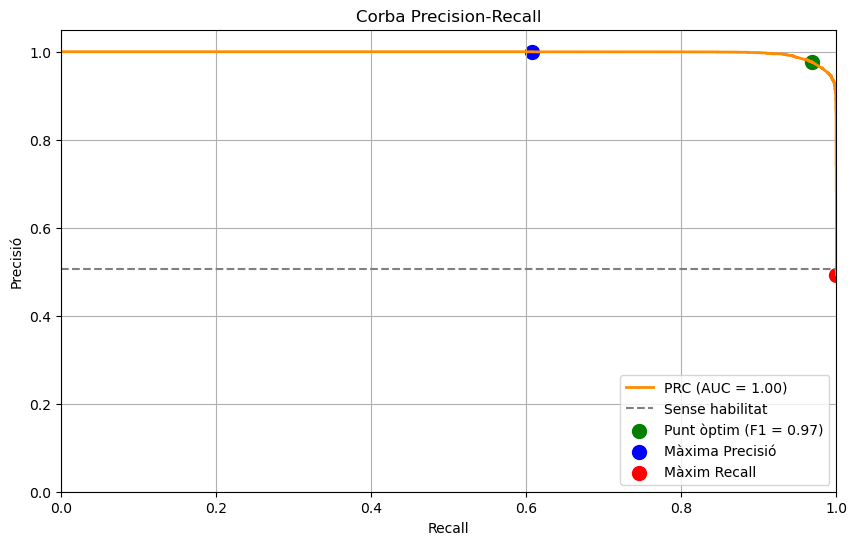

                  Llindar  Precisió/Recall/FPR  Recall/TPR
AUC              0.997730                  NaN         NaN
Punt Òptim (F1)  0.493044             0.976790    0.968719
Màxima Precisió  0.973154             1.000000    0.607712
Màxim Recall     0.000000             0.493591    1.000000


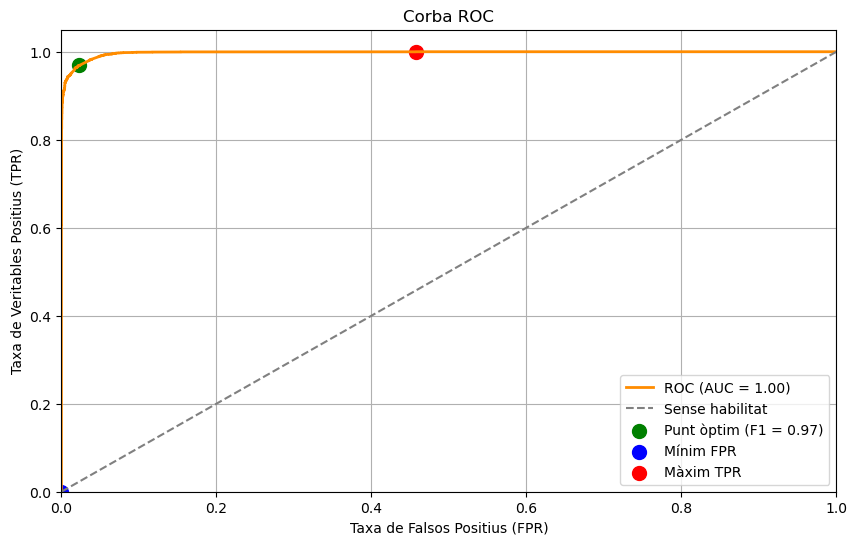

                  Llindar  Precisió/Recall/FPR  Recall/TPR
AUC              0.997732                  NaN         NaN
Punt Òptim (F1)  0.493044             0.022435    0.968719
Mínim FPR             inf             0.000000    0.000000
Màxim TPR        0.026273             0.457335    1.000000


In [32]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=26)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features='sqrt', min_samples_split=5, n_estimators=300, subsample=0.8)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=26)

scores = cross_val_score(gb, X_train, y_train, cv=kfold, scoring='accuracy')

acc_train = scores.mean()

gb.fit(X_train, y_train)
y_pred_test = gb.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy-Score (Train): {acc_train:.5f}')
print(f'Accuracy-Score (Test): {acc_test:.5f}')

plot_performance_curve(gb, X_test, y_test, 'pr')
plot_performance_curve(gb, X_test, y_test, 'roc')

Amb el nostre model hem pogut obtenir uns resultats molt positius, amb una precisió superior al 95%. Com podem observar als gràfics anteriors, també hem obtingut una mètrica de F1 pràcticament perfecta. Creiem que aquesta fita es deu a la baixa complexitat de les dades i a unes relacions fortes entre algunes variables i la nostra variable objectiu. 
En aquest cas, gràcies al model podem suggerir que millorar el control dels objectius de la partida i centrar-se en destruïr torres és la millor manera per millorar les teves posiblitats de guanyar la partida.